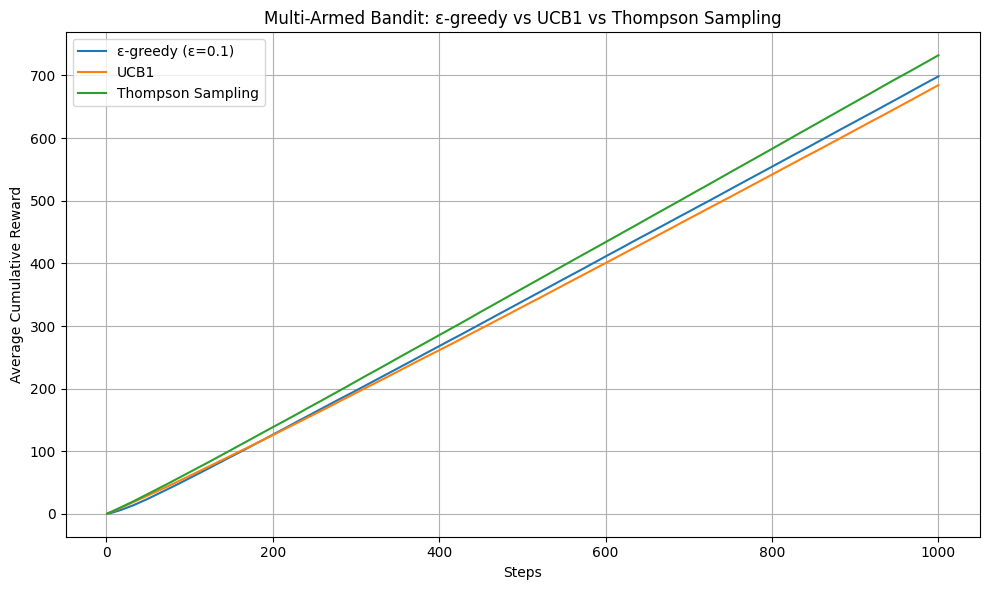

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. 多臂老虎机环境
# =========================

class BernoulliBandit:
    def __init__(self, probs):
        """
        probs: list/array, 每个臂的真实中奖概率 p_a
        """
        self.probs = np.array(probs)
        self.k = len(probs)

    def step(self, action):
        """
        action: 选择的臂编号 (0 ~ k-1)
        返回: 奖励 0 或 1
        """
        p = self.probs[action]
        return np.random.rand() < p  # True/False -> 1/0 自动转换为 int

# =========================
# 2. ε-greedy 算法
# =========================

class EpsilonGreedyAgent:
    def __init__(self, k, epsilon=0.1):
        self.k = k
        self.epsilon = epsilon
        self.reset()

    def reset(self):
        self.counts = np.zeros(self.k, dtype=int)      # 每个臂的选择次数 N_a
        self.values = np.zeros(self.k, dtype=float)    # 每个臂的平均奖励估计 Q_a

    def select_action(self):
        # 以 epsilon 的概率随机探索
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        # 否则选择当前估计最好的臂
        return np.argmax(self.values)

    def update(self, action, reward):
        """
        用增量公式更新该臂的平均奖励
        """
        self.counts[action] += 1
        n = self.counts[action]
        q_old = self.values[action]
        self.values[action] = q_old + (reward - q_old) / n

# =========================
# 3. UCB1 算法
# =========================

class UCBAgent:
    def __init__(self, k):
        self.k = k
        self.reset()

    def reset(self):
        self.counts = np.zeros(self.k, dtype=int)
        self.values = np.zeros(self.k, dtype=float)
        self.total_count = 0  # t

    def select_action(self):
        self.total_count += 1
        t = self.total_count

        # 先保证每个臂至少选一次，避免除以 0
        for a in range(self.k):
            if self.counts[a] == 0:
                return a

        # 计算每个臂的 UCB 值
        ucb_values = np.zeros(self.k)
        for a in range(self.k):
            avg = self.values[a]
            n_a = self.counts[a]
            # UCB1 上界公式：Q_hat + sqrt(2 ln t / N_a)
            bonus = np.sqrt(2 * np.log(t) / n_a)
            ucb_values[a] = avg + bonus

        return np.argmax(ucb_values)

    def update(self, action, reward):
        self.counts[action] += 1
        n = self.counts[action]
        q_old = self.values[action]
        self.values[action] = q_old + (reward - q_old) / n

# =========================
# 4. Thompson Sampling (Beta-Bernoulli)
# =========================

class ThompsonSamplingAgent:
    def __init__(self, k):
        self.k = k
        self.reset()

    def reset(self):
        # Beta(α, β)，初始为 Beta(1,1) = Uniform(0,1)
        self.alpha = np.ones(self.k, dtype=float)
        self.beta = np.ones(self.k, dtype=float)

    def select_action(self):
        # 对每个臂从 Beta 分布采样一个候选概率
        samples = np.random.beta(self.alpha, self.beta)
        return np.argmax(samples)

    def update(self, action, reward):
        # reward 是 0 或 1
        if reward == 1:
            self.alpha[action] += 1
        else:
            self.beta[action] += 1

# =========================
# 5. 运行多次实验，比较三种算法
# =========================

def run_bandit_experiment(
    bandit_probs,
    n_steps=1000,
    n_runs=100,
    epsilon=0.1
):
    """
    bandit_probs: 每个臂的真实概率列表
    n_steps: 每个 run 内的时间步数
    n_runs: 重复独立实验次数，用来取平均（平滑曲线）
    epsilon: ε-greedy 的 ε
    """

    k = len(bandit_probs)

    # 用来累积各方法在每个时间步上的奖励（方便后面 / n_runs）
    rewards_eps = np.zeros(n_steps)
    rewards_ucb = np.zeros(n_steps)
    rewards_ts = np.zeros(n_steps)

    for run in range(n_runs):
        bandit = BernoulliBandit(bandit_probs)
        agent_eps = EpsilonGreedyAgent(k, epsilon=epsilon)
        agent_ucb = UCBAgent(k)
        agent_ts = ThompsonSamplingAgent(k)

        # 每个 run 内的累积奖励
        total_reward_eps = 0
        total_reward_ucb = 0
        total_reward_ts = 0

        cum_rewards_eps = np.zeros(n_steps)
        cum_rewards_ucb = np.zeros(n_steps)
        cum_rewards_ts = np.zeros(n_steps)

        for t in range(n_steps):
            # ---- ε-greedy ----
            a_eps = agent_eps.select_action()
            r_eps = int(bandit.step(a_eps))
            agent_eps.update(a_eps, r_eps)
            total_reward_eps += r_eps
            cum_rewards_eps[t] = total_reward_eps

            # ---- UCB1 ----
            a_ucb = agent_ucb.select_action()
            r_ucb = int(bandit.step(a_ucb))
            agent_ucb.update(a_ucb, r_ucb)
            total_reward_ucb += r_ucb
            cum_rewards_ucb[t] = total_reward_ucb

            # ---- Thompson Sampling ----
            a_ts = agent_ts.select_action()
            r_ts = int(bandit.step(a_ts))
            agent_ts.update(a_ts, r_ts)
            total_reward_ts += r_ts
            cum_rewards_ts[t] = total_reward_ts

        # 把本次 run 的结果累加起来，后面除以 n_runs 得到平均曲线
        rewards_eps += cum_rewards_eps
        rewards_ucb += cum_rewards_ucb
        rewards_ts += cum_rewards_ts

    # 取平均
    rewards_eps /= n_runs
    rewards_ucb /= n_runs
    rewards_ts /= n_runs

    return rewards_eps, rewards_ucb, rewards_ts

# =========================
# 6. 主程序：定义环境，画图
# =========================

if __name__ == "__main__":
    # 设定一个多臂老虎机环境，各臂的真实中奖概率
    # 例如：臂0=0.2, 臂1=0.5, 臂2=0.75, 臂3=0.6
    true_probs = [0.2, 0.5, 0.75, 0.6]

    n_steps = 1000
    n_runs = 200  # 多跑几次让曲线更平滑
    epsilon = 0.1

    rewards_eps, rewards_ucb, rewards_ts = run_bandit_experiment(
        true_probs,
        n_steps=n_steps,
        n_runs=n_runs,
        epsilon=epsilon
    )

    # 画出平均累积奖励曲线
    x = np.arange(1, n_steps + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(x, rewards_eps, label=f"ε-greedy (ε={epsilon})")
    plt.plot(x, rewards_ucb, label="UCB1")
    plt.plot(x, rewards_ts, label="Thompson Sampling")

    plt.xlabel("Steps")
    plt.ylabel("Average Cumulative Reward")
    plt.title("Multi-Armed Bandit: ε-greedy vs UCB1 vs Thompson Sampling")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
